[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

# Breakpoints 断点

## Review 回顾

在实现 `human-in-the-loop` 时，我们通常希望在图运行过程中查看其输出。

我们通过流式处理为此打下了基础。

## Goals 目标

现在，让我们讨论 `human-in-the-loop` 的动机：

1. **`Approval`** - 我们可以中断代理，将状态展示给用户，并允许用户接受某个操作。
2. **`Debugging`** - 我们可以回溯图的执行，以复现或避免问题。
3. **`Editing`** - 我们可以修改状态。

LangGraph 提供了多种方式来获取或更新代理状态，以支持各种 `human-in-the-loop` 工作流。

首先，我们将介绍 [断点](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage)，这是一种在特定步骤中断图的简单方法。

接下来，我们将展示如何通过断点实现用户 `approval`。

In [1]:
import getpass 
import os 

api_key = getpass.getpass("Enter your API key: ")
os.environ["OPENAI_API_KEY"] = api_key

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## 用于用户批准的断点 breakpoints

让我们重新审视第1模块中使用的简单代理。

假设我们对工具的使用有所顾虑：我们希望在代理使用其工具之前进行批准。

我们只需在**编译**图时设置 `interrupt_before=["tools"]`，其中 `tools` 是我们的工具节点。

这意味着执行将在 `tools` 节点（即执行工具调用的节点）之前被中断。


In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

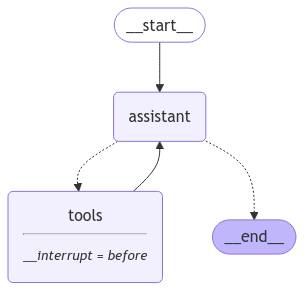

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Wdnhct1yR96zQBsxl0Q26Mbd)
 Call ID: call_Wdnhct1yR96zQBsxl0Q26Mbd
  Args:
    a: 2
    b: 3


我们可以获取当前的图状态，并查看下一个将被调用的节点。

这是一种确认图已被中断的有效方法。 

In [5]:
state = graph.get_state(thread)
state.next

('tools',)

现在，我们来介绍一个实用的小技巧。

当我们使用 `None` 调用图时，它将从上一次的状态检查点继续执行！

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

为了清晰起见，LangGraph 会重新发出当前状态，其中包含调用工具的 `AIMessage`。

然后，它将继续执行图中的后续步骤，从工具节点开始。

我们可以看到工具节点使用此工具调用运行，并将结果传递回聊天模型，生成我们的最终答案。

In [6]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_Wdnhct1yR96zQBsxl0Q26Mbd)
 Call ID: call_Wdnhct1yR96zQBsxl0Q26Mbd
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


现在，让我们结合这些内容，添加一个特定的用户批准步骤，该步骤可以接收用户输入。

In [7]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7lmiUsKr2l8tIzsdGn97H8FG)
 Call ID: call_7lmiUsKr2l8tIzsdGn97H8FG
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_7lmiUsKr2l8tIzsdGn97H8FG)
 Call ID: call_7lmiUsKr2l8tIzsdGn97H8FG
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


中间需要人为输入 “yes” 或 “no”：

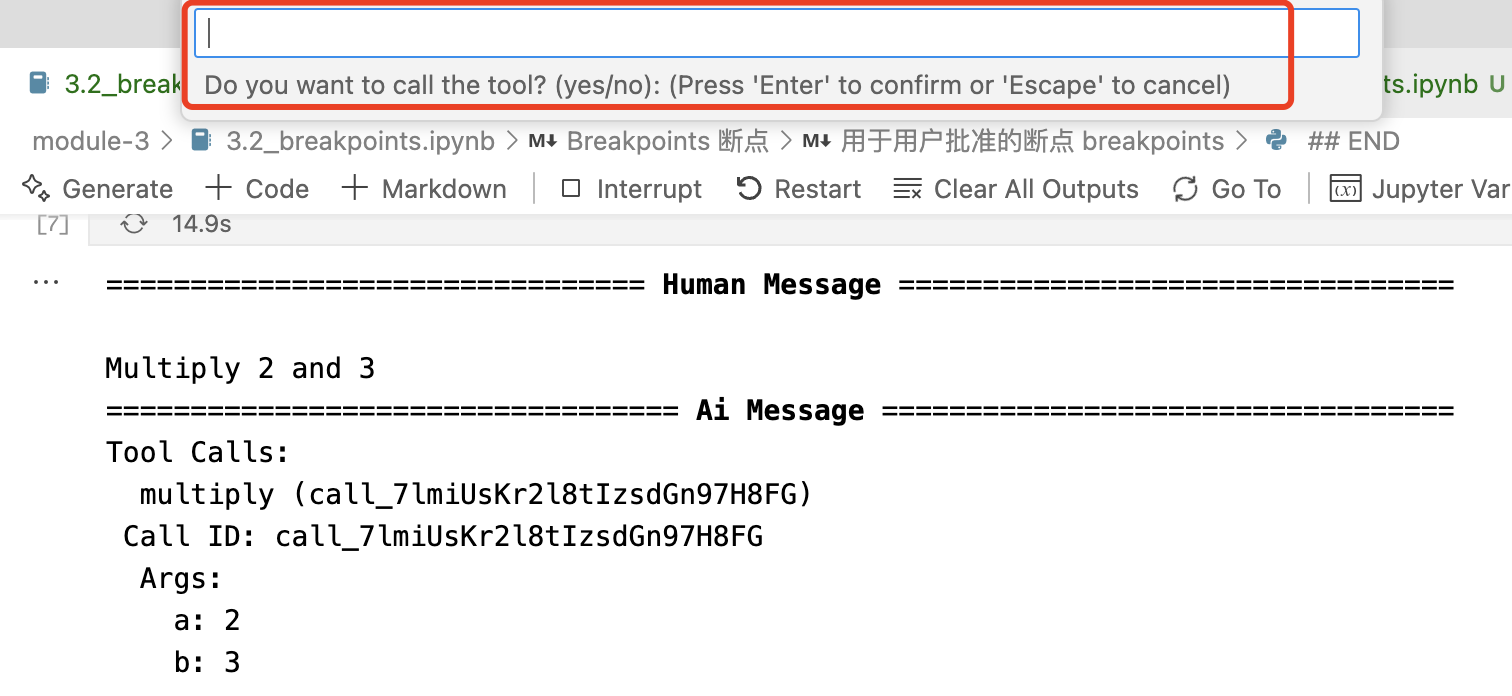

In [ ]:
## END